# Выбор локации для скважины

## Описание проекта <a id="1"></a>

Необходимо орпеделить оптимальную локацию для бурения новой скважины.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Содержание: <a id="toc"></a>

1. [Описание проекта](#1)
2. [Содержание](#2)
3. [Условия проекта](#3)
4. [Загрузка и подготовка данных](#4)
5. [Обучение и проверка модели](#5)
6. [Подготовка к расчёту прибыли](#6)
7. [Расчёт прибыли и рисков](#7)
8. [Общий вывод](#8)

## Условия проекта <a id="3"></a>

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).   
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
- Бюджет на разработку скважин в регионе — 10 млрд рублей.  
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

## Загрузка и подготовка данных <a id="4"></a>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Изучение файла

Данные геологоразведки трёх регионов сохраним в переменных df1, df2, df3:

In [3]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')

In [4]:
df2 = pd.read_csv('/datasets/geo_data_1.csv')

In [5]:
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [6]:
df1.head(2)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062
1,2acmU,1.334711,-0.340164,4.36508,73.037750


In [7]:
df2.head(2)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261


In [8]:
df3.head(2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


**Признаки**
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  

**Целевой признак**
- product — объём запасов в скважине (тыс. баррелей).

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
df1.duplicated().sum()

0

In [13]:
df2.duplicated().sum()

0

In [14]:
df3.duplicated().sum()

0

In [15]:
df1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [16]:
df2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [17]:
df3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


###  Оценка мультиколлинеарности признаков.

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


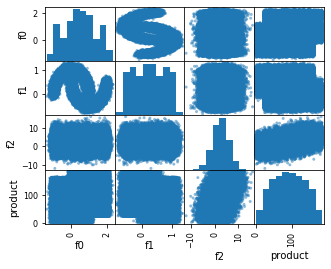

In [18]:
pd.plotting.scatter_matrix(df1, figsize=(5, 4));
df1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


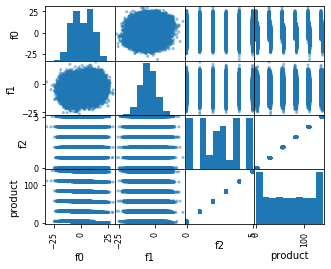

In [19]:
pd.plotting.scatter_matrix(df2, figsize=(5, 4));
df2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


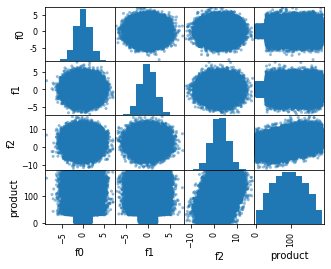

In [20]:
pd.plotting.scatter_matrix(df3, figsize=(5, 4));
df3.corr()

###  Вывод. Изучение файла

1. Целевой признак количественный. Для построения модели будем исполльзовать алгоритм линейной регрессии.
2. id — уникальный идентификатор скважины. Не несет полезной информации для построения модели. Удалим данный столбец при построении модели.
3. Пропущееных значений не обнаружено. Необходимые для построения признаки имеют подходящий формат.
4. Дубликаты отсутствуют.
5. В трех таблицах встречаются значения product равные нулю. Что может указывать на то, что данные скважины пусты.
6. Значения признаков f0, f1, f2 имеют схожий масштаб, однако для увеличения точности необходимо их масштабировать.
7. Проверка на мультиколлиенарность признаков показала, что второе месторождение имеет признак f2 полностью коррелирующий с признаком product. Данным признаком можно было бы пренебречь. Однако, результаты проверки на 1 и 3 месторождении не имеют такой тенденции, и удаление признака f2 у 1 и 3 модели могут иметь негативные последствия.

## Обучение и проверка модели <a id="5"></a>

Обучим и проверим модели для каждого региона. Для этого необходимо:
-  Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
-  Стандартизировать данные.
-  Обучить модель и сделать предсказания на валидационной выборке.
-  Сохранить предсказания и правильные ответы на валидационной выборке.
-  Напечатать на экране средний запас предсказанного сырья и RMSE модели.
-  Проанализировать результаты.

Для обучения модели построим функциию, которая:
- Принимает на входе необходимый датасет.
- Разбивает данные на обучающую и валидационную выборки в соотношении 75:25, при этом не использует негативный признак id.
- Стандартизирует данные.
- Обучает модель с помощью алгоритма линейной регрессии.
- Делает предсказания.
- Рассчитывает средний запас предсказанного сырья и RMSE модели (два знака после запятой).
- Сохраняет предсказания и правильные ответы на валидационной выборке.

In [21]:
def calculation_of_parameters(data):  
    features = data.drop(["product","id"], axis=1)
    target = data["product"]
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345)
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    LR = LinearRegression(normalize=False)
    LR.fit(features_train, target_train)
    predictions = LR.predict(features_valid)
    predictions = pd.Series(predictions)
    average_product_stock_prediction = sum(predictions) / len(predictions)
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    
    print("Средний запас предсказанного сырья: {0:.2f}".format(average_product_stock_prediction))
    print("RMSE модели: {0:.2f}".format(rmse))
    return (predictions, target_valid.reset_index(drop=True), rmse)

Рассчитаем значения для трех регионов и сохраним необходимые параметры для каждого региона в переменные:

In [22]:
print('Регион 1:')
predictions_1, target_valid_1, rmse_1 = calculation_of_parameters(df1)
print(' ')
print('Регион 2:')
predictions_2, target_valid_2, rmse_2 = calculation_of_parameters(df2)
print(' ')
print('Регион 3:')
predictions_3, target_valid_3, rmse_3 = calculation_of_parameters(df3)

Регион 1:
Средний запас предсказанного сырья: 92.59
RMSE модели: 37.58
 
Регион 2:
Средний запас предсказанного сырья: 68.73
RMSE модели: 0.89
 
Регион 3:
Средний запас предсказанного сырья: 94.97
RMSE модели: 40.03


### Вывод. Обучение и проверка модели
1. Средние запасы предсказанного сырья схожи с средними реальными запасами, что говорит о одекватности модели.
2. Наилучший показатель  RMSE демонстрирует модель 2 региона. Вероятно, это свыязано с тем, что признак f2 полностью коррелирует с целевым признаком product.

## Подготовка к расчёту прибыли <a id="6"></a>

1. Необходимо рассчитать достаточный объём сырья для безубыточной разработки новой скважины и сравнить полученный объём сырья со средним запасом в каждом регионе. Для этого необходимо определить **точку безубыточности (n = достаточный объём сырья для безубыточной разработки новой скважины)**, равную отношению буджета на разработку скважины в регионе (**budget**) к стоимости сырья (**price_per_thousand_barrels**).  
> -  Бюджет на разработку скважин в регионе — 10 млрд рублей.  
> - Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.   
> - Рассчет производится исходя из того, что будут отобраны 200 лучших для разработки скважин в каждом регионе.

In [23]:
budget = 10**10
income_per_thousand_barrels = 450*1000
n = budget / income_per_thousand_barrels
print('Точка безубыточности равна: {:.0f} тысяч баррелей'.format(n))

Точка безубыточности равна: 22222 тысяч баррелей


2. Рассчитаем средний объем скважины, необходимый для безубыточной разработки:

In [24]:
print('Cредний объем скважины, необходимый для безубыточной разработки равен:', np.ceil(n/200) ,'тысяч баррелей.')

Cредний объем скважины, необходимый для безубыточной разработки равен: 112.0 тысяч баррелей.


### Вывод.Подготовка к расчёту прибыли

1. 200 лучших скажин выбранного региона должны иметь объем не менее 22222 тысяч баррелей продукции.
2. Каждая скважина должна приносить в среднем не менее 112.0 тысяч баррелей.
3. Полученный объем скважины, необходимый для безубыточной разработки, больше средних значений по регионам. Однако данный вывод относится ко все 500 скважинам. Сравнение с 200 лучшими скважинами по каждому региону может иметь другой результат.

## Расчёт прибыли и рисков  <a id="7"></a>

1. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели (200 лучших скважин). Прибылью будем считать разницу полученного дохода и заложенного бюджета.

In [ ]:
def profit(predictions, target):
    top_predictions = predictions.sort_values(ascending=False)
    top_target = target[top_predictions.index][:200]
    revenue = top_target.sum() * income_per_thousand_barrels
    return revenue - budget

In [26]:
print('Прибыль Региона 1 по двухстам лучшим скважинам составит: {:.1f} рублей.'.format(profit(predictions_1, target_valid_1)))
print('Прибыль Региона 2 по двухстам лучшим скважинам составит: {:.1f} рублей.'.format(profit(predictions_2, target_valid_2)))
print('Прибыль Региона 3 по двухстам лучшим скважинам составит: {:.1f} рублей.'.format(profit(predictions_3, target_valid_3)))

Прибыль Региона 1 по двухстам лучшим скважинам составит: 3320826043.1 рублей.
Прибыль Региона 2 по двухстам лучшим скважинам составит: 2415086696.7 рублей.
Прибыль Региона 3 по двухстам лучшим скважинам составит: 2710349963.6 рублей.


2. Посчитаем риски и прибыль для каждого региона, для этого:
> - Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.  
> - Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

> - Для 95% доверительного интервала примем кванили равные 2.5% и 97.5%. Границы доверительного интервала определим при помощи метода np.percentile().
> - Риск убытка в процентах(значений прибыли меньше нуля) оценим при помощи метода st.percentileofscore().

In [27]:
def confidence_interval_mean_revenue_and_loss_risk(predictions, target):
    state = np.random.RandomState(12345)
    revenue = []
    for i in range(1000):
        target_sample = target.sample(n=500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        revenue.append(profit(predictions_sample, target_sample))
        
    lower = int(np.percentile(revenue, 2.5))
    higher = int(np.percentile(revenue, 97.5))
    mean_revenue = int(sum(revenue) / len(revenue))
    risk = st.percentileofscore(revenue, 0)

    return ((lower, higher), mean_revenue, risk)

In [30]:
interval_1, mean_revenue_1, risk_1 = confidence_interval_mean_revenue_and_loss_risk(predictions_1, target_valid_1)
interval_2, mean_revenue_2, risk_2 = confidence_interval_mean_revenue_and_loss_risk(predictions_2, target_valid_2)
interval_3, mean_revenue_3, risk_3 = confidence_interval_mean_revenue_and_loss_risk(predictions_3, target_valid_3)

In [32]:
print('Регион 1')
print('Средняя прибыль:',mean_revenue_1)
print('Доверительный интервал:',interval_1)
print('Риск убытков:',risk_1)
print('')
print('Регион 2')
print('Средняя прибыль:',mean_revenue_2)
print('Доверительный интервал:',interval_2)
print('Риск убытков:',risk_2)
print('')
print('Регион 3')
print('Средняя прибыль:',mean_revenue_3)
print('Доверительный интервал:',interval_3)
print('Риск убытков:',risk_3)

Регион 1
Средняя прибыль: 425938526
Доверительный интервал: (-102090094, 947976353)
Риск убытков: 6.0

Регион 2
Средняя прибыль: 515222773
Доверительный интервал: (68873225, 931547591)
Риск убытков: 1.0

Регион 3
Средняя прибыль: 435008362
Доверительный интервал: (-128880547, 969706954)
Риск убытков: 6.4


### Вывод. Расчёт прибыли и рисков 
1. Все регионы имеют положительную среднюю прибыль.
2. Регион №2 - единственный регион, имеющий вероятность убытков меньше 2.5%

## Общий вывод <a id="8"></a>
- Проведен анализ и обработка полученных данных.
- Определен алгоритм построения модели.
- Признаки стандартизированны.
- Наилучший показатель RMSE продемонстрировала модель Региона №2.
- Cредний объем скважины, необходимый для безубыточной разработки равен: 112.0 тысяч баррелей.
- Регион №2 - единственный регион, имеющий вероятность убытков меньше 2.5%
- Регион №2 - место, где добыча принесёт наибольшую прибыль, c наименшими рисками.